## Mixed FEM
Flow through a porous medium.

In [1]:
using LinearAlgebra
using StaticArrays
using SparseArrays
using PyPlot

In [2]:
abstract type Cell end
abstract type Triangle end
abstract type Quadrilateral end

In [3]:
struct N1curl <: Triangle      end # Nédélec (first kind) on a reference triangle
struct Qcurl  <: Quadrilateral end # Nédélec (first kind) on a reference quadrilateral

In [4]:
struct N1div <: Triangle      end  # Raviart-Thomas on a reference triangle
struct Qdiv  <: Quadrilateral end  # Raviart-Thomas on a reference quadrilateral

In [5]:
struct P0 <: Cell end # Piecewise-constant

In [6]:
function deleterepeatedrows(vertices)
    sorted = sort(vertices, dims=2) # sort in rows
    unique = Tuple[] # unique edges
    idxs   = Int64[] # indices for original edges
    rows   = Int64[] # indices for unique edges
    for i in axes(sorted,1)
        test = tuple(sorted[i,:]...)
        if test ∉ unique
            push!(unique, test)
            push!(idxs, i)
        end
    
        row = findfirst(==(test), unique)
        if row ≠ nothing
            push!(rows, row)
        end
    end
    
    return rows, idxs
end

deleterepeatedrows (generic function with 1 method)

In [7]:
function get_edges(element::Triangle, elems2nodes)
    nelems = size(elems2nodes, 1)
    
    # extracts sets of edges
    edges1=elems2nodes[:,[2,3]]
    edges2=elems2nodes[:,[3,1]]
    edges3=elems2nodes[:,[1,2]]
    
    # as sets of their nodes (vertices)
    vertices=zeros(Int64,nelems*3,2)
    vertices[1:3:end,:].=edges1
    vertices[2:3:end,:].=edges2
    vertices[3:3:end,:].=edges3
    
    # repeated sets of nodes (joint edges) are eliminated 
    rows, index = deleterepeatedrows(vertices)
    elems2edges = copy(transpose(reshape(rows, 3, :)))
    edges2nodes = copy(vertices[index,:])
    return elems2edges, edges2nodes
end

get_edges (generic function with 1 method)

In [8]:
function get_edges(element::Quadrilateral, elems2nodes)
    nelems = size(elems2nodes, 1)
    
    # extracts sets of edges
    edges1=elems2nodes[:,[1,2]]
    edges2=elems2nodes[:,[2,3]]
    edges3=elems2nodes[:,[3,4]]
    edges4=elems2nodes[:,[4,1]]
    
    # as sets of their nodes (vertices)
    vertices=zeros(Int64,nelems*4,2)
    vertices[1:4:end,:].=edges1
    vertices[2:4:end,:].=edges2
    vertices[3:4:end,:].=edges3
    vertices[4:4:end,:].=edges4
    
    # repeated sets of nodes (joint edges) are eliminated 
    rows, index = deleterepeatedrows(vertices)
    elems2edges = copy(transpose(reshape(rows, 4, :)))
    edges2nodes = copy(vertices[index,:])
    return elems2edges, edges2nodes
end

get_edges (generic function with 2 methods)

In [9]:
function piola_transformation(element::Triangle, nodes2coord, elems2nodes)
    # initialize
    nelems = size(elems2nodes,1)
    B_K    = zeros(2, 2, nelems)

    # points defining the triangles
    A = nodes2coord[elems2nodes[:,1],1:2]
    B = nodes2coord[elems2nodes[:,2],1:2]
    C = nodes2coord[elems2nodes[:,3],1:2]
    
    # vectors defining the triangle
    a = B - A
    b = C - A

    # the affine mapping F_K = B_K * x + b_K
    B_K[:,1,:].= a'
    B_K[:,2,:].= b'

    # determinant
    B_K_det = @. a[:,1] * b[:,2] - a[:,2] * b[:,1]
    
    return B_K, B_K_det
end

piola_transformation (generic function with 1 method)

In [10]:
function piola_transformation(element::Quadrilateral, nodes2coord, elems2nodes)
    # initialize
    nelems = size(elems2nodes,1)
    B_K    = zeros(2, 2, nelems)

    # points defining the quads
    A = nodes2coord[elems2nodes[:,1],1:2]
    B = nodes2coord[elems2nodes[:,2],1:2]
    C = nodes2coord[elems2nodes[:,3],1:2]
    D = nodes2coord[elems2nodes[:,4],1:2]
    
    # vectors defining the quad
    a = B - A
    b = D - A

    # the affine mapping F_K = B_K * x + b_K
    B_K[:,1,:].= a'
    B_K[:,2,:].= b'

    # determinants
    B_K_det = @. a[:,1] * b[:,2] - a[:,2] * b[:,1]
    
    return B_K, B_K_det
end

piola_transformation (generic function with 2 methods)

In [133]:
function orientation(elems2nodes, edges2nodes, elems2edges)
    nelem = size(elems2nodes,1)
    nedge = size(elems2nodes,2)
    signs = ones(nelem, nedge)
    
    for k=1:nelem
        for j=1:nedge
            n1edge = edges2nodes[elems2edges[k,j], 1]
            n1elem = elems2nodes[k,j]
            signs[k,j] = (n1edge == n1elem) ? +1 : -1
        end
    end
    
    return signs
end

orientation (generic function with 2 methods)

In [134]:
function quadrature(element::Triangle)
    ip = [1/6 2/3; 2/3 1/6; 1/6 1/6]
    wg = [1/6,1/6,1/6]
    
    return ip, wg, 3
end

function quadrature(element::Quadrilateral)
    pt = 1/2√3
    ip = [-pt -pt; +pt -pt; -pt +pt; +pt +pt] .+ 1/2
    wg = [1/4,1/4,1/4,1/4]
    
    return ip, wg, 4
end

quadrature (generic function with 2 methods)

In [135]:
function basis(element::N1curl, p)
    np  = size(p, 1)
    val = zeros(np, 2, 3)
    rot = zeros(np, 1, 3)

    # calculate basis function values
    val[:,:,1] = [-p[:,2]       p[:,1]      ]
    val[:,:,2] = [-p[:,2]       p[:,1] .- 1.]
    val[:,:,3] = [ 1. .- p[:,2] p[:,1]      ]

    # calculate basis function curl values
    rot .+= 2.0
    
    return val, rot, 3
end

basis (generic function with 3 methods)

In [136]:
function basis(element::N1div, p)
    np  = size(p, 1)
    val = zeros(np, 2, 3)
    div = zeros(np, 1, 3)

    # calculate basis function values
    val[:,:,1] = [p[:,1]       p[:,2]      ]
    val[:,:,2] = [p[:,1] .- 1. p[:,2]      ]
    val[:,:,3] = [p[:,1]       p[:,2] .- 1.]

    # calculate basis function divergence values
    div .+= 2.0
    
    return val, div, 3
end

basis (generic function with 3 methods)

In [137]:
function basis(element::Qdiv, p)
    np  = size(p, 1)
    val = zeros(np, 2, 4)
    div = zeros(np, 1, 4)
    
    # calculate basis function values
    val[:,:,1] = [1.0p[:,1]        0.0p[:,2]]
    val[:,:,2] = [0.0p[:,1]        1.0p[:,2]]
    val[:,:,3] = [1.0p[:,1] .- 1.0 0.0p[:,2]]
    val[:,:,4] = [0.0p[:,1]        1.0p[:,2] .- 1.0]

    # calculate basis function divergence values
    div .+= 1.0
    
    return val, div, 4
end

basis (generic function with 3 methods)

In [16]:
## Matrices assembly procedures

In [17]:
function stiffness_matrix(element::Union{N1div, Qdiv}, elems2edge, B_K_det, signs, dofs)
    nelems = size(elems2edge,1)      # number of elements
    nedges = maximum(elems2edge)     # number of edges
    ip, w, nip = quadrature(element) # integration points and weights
    B_K_invabsdet = [inv(abs(x)) for x in B_K_det]
    
    # reference basis function div values on integration points,
    # and number of basis functions
    _, div, nbasis = basis(element, ip)
    
    # calculate all local stiffness matrices simultaneously
    Se = zeros(nbasis,nbasis,nelems)
    for i=1:nip
        for m=1:nbasis
            for k=1:nbasis
                for l=1:nelems
                    Se[m,k,l] += w[i] * B_K_invabsdet[l] *
                                 signs[l,m] * div[i,1,m] *
                                 signs[l,k] * div[i,1,k]
                end
            end
        end
    end
    
    # assemble global stiffness matrix
    S = spzeros(nedges, nedges)
    for l=1:nelems
        for m=1:nbasis
            e1 = dofs[elems2edge[l,m]]
            for k=1:nbasis
                e2 = dofs[elems2edge[l,k]]
                S[e1,e2] += Se[m,k,l]
            end
        end
    end
    
    return S
end

stiffness_matrix (generic function with 1 method)

In [18]:
function mass_matrix(element::Union{N1div, Qdiv}, elems2edge, B_K, B_K_det, signs, dofs)
    nelems = size(elems2edge,1);     # number of elements
    nedges = maximum(elems2edge)     # number of edges
    ip, w, nip = quadrature(element) # integration points and weights
    B_K_invabsdet = [inv(abs(x)) for x in B_K_det]

    # reference basis function curl values on integration points,
    # and number of basis functions
    val, _, nbasis = basis(element, ip)

    # calculate all local mass matrices simultaneously
    Me = zeros(nbasis, nbasis, nelems);

    for i=1:nip
        for m=1:nbasis
            for k=1:nbasis
                for l=1:nelems
                    Me[m,k,l] += w[i] * B_K_invabsdet[l] *
                                 dot(signs[l,m] * B_K[:,:,l] * val[i,:,m],
                                     signs[l,k] * B_K[:,:,l] * val[i,:,k])
                end
            end
        end
    end

    # assemble global mass matrix
    M = spzeros(nedges, nedges)
    for l=1:nelems
        for m=1:nbasis
            e1 = dofs[elems2edge[l,m]]
            for k=1:nbasis
                e2 = dofs[elems2edge[l,k]]
                M[e1,e2] += Me[m,k,l]
            end
        end
    end
    
    return M
end

mass_matrix (generic function with 1 method)

In [19]:
function div_matrix(element::Union{N1div, Qdiv}, elems2edge, B_K, B_K_det, signs, dofs)
    nelems = size(elems2edge,1)      # number of elements
    nedges = maximum(elems2edge)     # number of edges
    ip, w, nip = quadrature(element) # integration points and weights
    B_K_invabsdet = [inv(abs(x)) for x in B_K_det]

    # reference basis function curl values on integration points,
    # and number of basis functions
    _, div, nbasis = basis(element, ip)

    # calculate all local divergence matrices simultaneously
    De = zeros(nbasis,nelems);
    for m=1:nbasis
        for l=1:nelems
            De[m,l] += signs[l,m]
        end
    end

    # assemble global divergence matrix
    D = spzeros(nedges,nelems)
    for l=1:nelems
        for m=1:nbasis
            e = dofs[elems2edge[l,m]]
            D[e,l] += De[m,l]
        end
    end
    
    return D
end

div_matrix (generic function with 1 method)

In [183]:
f(x,y) = 1.0
#f(x,y) = sin(2π * x) * sin(2π * y) * 8.0 * π^2

f (generic function with 1 method)

In [184]:
function rhs_assembly(element::Triangle, nodes2coord, elems2node, B_K_det)
    P =(nodes2coord[elems2node[:,1],1:2] .+
        nodes2coord[elems2node[:,2],1:2] .+
        nodes2coord[elems2node[:,3],1:2])./ 3.0

    return -0.5 * abs.(B_K_det) .* f.(P[:,1], P[:,2])
end

rhs_assembly (generic function with 2 methods)

In [185]:
function rhs_assembly(element::Quadrilateral, nodes2coord, elems2node, B_K_det)
    P =(nodes2coord[elems2node[:,1],1:2] .+
        nodes2coord[elems2node[:,2],1:2] .+
        nodes2coord[elems2node[:,3],1:2] .+
        nodes2coord[elems2node[:,4],1:2])./ 4.0

    return -1.0 * abs.(B_K_det) .* f.(P[:,1], P[:,2])
end

rhs_assembly (generic function with 2 methods)

In [205]:
# define mesh
nodes2coord = [0.0 0.0; 1.0 0.0; 0.0 1.0; 1.0 1.0]
elems2nodes = [1 2 4; 1 3 4]

2×3 Matrix{Int64}:
 1  2  4
 1  3  4

In [206]:
using MAT
file = matopen("/Users/bach/fala/dpy.mat")
nodes2coord = read(file, "n2c")
elems2nodes = read(file, "e2n") .+ 1
solution = read(file, "x")
close(file)

In [207]:
if size(elems2nodes, 2) == 3 RT0 = N1div() end
if size(elems2nodes, 2) == 4 RT0 = Qdiv()  end
RT0

N1div()

In [203]:
elems2edges, edges2nodes = get_edges(RT0, elems2nodes);

In [189]:
B_K, B_K_det = piola_transformation(RT0, nodes2coord, elems2nodes);

In [190]:
signs = diagm(sign.(B_K_det)) * orientation(elems2nodes, edges2nodes, elems2edges)

8×3 Matrix{Float64}:
 -1.0  -1.0  -1.0
 -1.0  -1.0  -1.0
  1.0   1.0   1.0
  1.0   1.0   1.0
 -1.0  -1.0  -1.0
  1.0   1.0   1.0
  1.0   1.0   1.0
 -1.0  -1.0  -1.0

In [191]:
dofs = collect(1:maximum(elems2edges));

In [192]:
S = stiffness_matrix(RT0, elems2edges, B_K_det, signs, dofs)

16×16 SparseMatrixCSC{Float64, Int64} with 64 stored entries:
⡿⢏⣁⡐⠂⠀⠀⠀
⢁⠸⠱⢆⣀⡀⠀⠒
⠈⠀⠀⠸⢱⢖⡂⠀
⠀⠀⢠⠀⠈⠈⠿⣧

In [193]:
M = mass_matrix(RT0, elems2edges, B_K, B_K_det, signs, dofs)
droptol!(M, 1e-15)

16×16 SparseMatrixCSC{Float64, Int64} with 32 stored entries:
⠕⢅⠁⠀⠀⠀⠀⠀
⠁⠀⠱⢆⡀⡀⠀⠐
⠀⠀⠀⠨⠑⢄⡀⠀
⠀⠀⢀⠀⠀⠈⠛⢄

In [194]:
D = div_matrix(RT0, elems2edges, B_K, B_K_det, signs, dofs)

16×8 SparseMatrixCSC{Float64, Int64} with 24 stored entries:
⢏⡐⠀⠀
⠈⢆⡀⠐
⠀⠈⢖⠀
⠀⠀⠈⢧

In [195]:
g = rhs_assembly(RT0, nodes2coord, elems2nodes, B_K_det);

In [196]:
# prepare rest of vectors/matrices
nedges = size(M, 1)
nelems = size(elems2edges, 1)

# auxiliary vectors/matrices
z = zeros(nedges, 1)
b = [z; g];
# assemble an infinite saddle-point matrix
Z = spzeros(nelems, nelems)
A = [M D; D' Z]

24×24 SparseMatrixCSC{Float64, Int64} with 80 stored entries:
⠕⢅⠁⠀⠀⠀⠀⠀⢏⡐⠀⠀
⠁⠀⠱⢆⡀⡀⠀⠐⠈⢆⡀⠐
⠀⠀⠀⠨⠑⢄⡀⠀⠀⠈⢖⠀
⠀⠀⢀⠀⠀⠈⠛⢄⠀⠀⠈⢧
⢋⠱⠢⢄⡀⠀⠀⠀⠀⠀⠀⠀
⠀⠀⢀⠈⠘⠑⠦⣄⠀⠀⠀⠀

In [197]:
u = A \ b

24×1 Matrix{Float64}:
  0.08333333333333334
 -0.04166666666666666
  0.0833333333333333
 -0.04166666666666665
  0.08333333333333334
 -1.7293024651143796e-17
 -0.08333333333333334
 -1.9949319973733282e-17
 -0.08333333333333331
  0.04166666666666668
  0.08333333333333331
 -0.08333333333333337
 -0.08333333333333333
 -0.08333333333333334
  0.04166666666666667
  0.08333333333333334
  0.013888888888888885
  0.013888888888888892
  0.02777777777777778
  0.027777777777777773
  0.027777777777777776
  0.013888888888888888
  0.013888888888888885
  0.027777777777777776

In [198]:
function show_mesh(element::Triangle, nodes2coord, elems2nodes)
    triplot(nodes2coord[:,1], nodes2coord[:,2], triangles=(elems2nodes .- 1), "-k")
    return nothing
end

show_mesh (generic function with 1 method)

In [199]:
function show_scalar_field(element::P0, nodes2coord, elems2nodes, u)
    n = size(elems2nodes,1)
    m = size(elems2nodes,2)
    
    P   = zeros(n,2)
    for i=1:m
        P .+= nodes2coord[elems2nodes[:,i],1:2]
    end
    P ./= m
    
    fig = figure()
    ax = fig.add_subplot(projection="3d")
    ax.scatter(P[:,1], P[:,2], u, c=u, cmap="viridis")
    ax.view_init(35, 35)
    
    return nothing
end

show_scalar_field (generic function with 1 method)

In [200]:
function show_vector_field(element::Union{N1div, Qdiv}, nodes2coord, edges2nodes, u)
    n = size(nodes2coord,1)
    m = size(edges2nodes,1)
    
    midpoints = (nodes2coord[edges2nodes[:,1],:] .+ nodes2coord[edges2nodes[:,2],:]) ./ 2.0
    vectors   = (nodes2coord[edges2nodes[:,1],:] .- nodes2coord[edges2nodes[:,2],:])
    normals   = [+vectors[:,2] -vectors[:,1]]
    
    scatter(midpoints[:,1], midpoints[:,2], color="k", marker=".", s=3)
    quiver(midpoints[:,1], midpoints[:,2], normals[:,1] .* u, normals[:,2] .* u, abs.(u),
        pivot="middle", headwidth=3, width=0.005, cmap="viridis")
end

show_vector_field (generic function with 1 method)

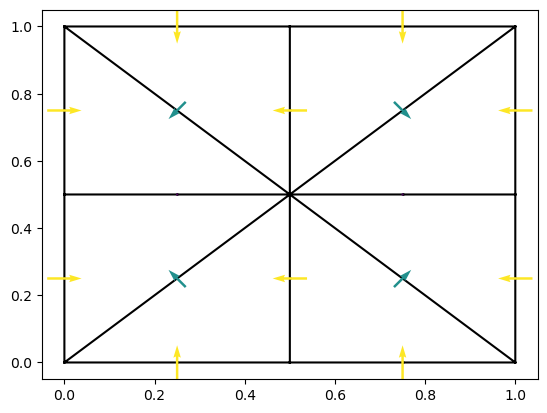

PyObject <matplotlib.quiver.Quiver object at 0x2a8d33e50>

In [202]:
show_mesh(RT0, nodes2coord, elems2nodes)
show_vector_field(RT0, nodes2coord, edges2nodes, view(u, 1:nedges))

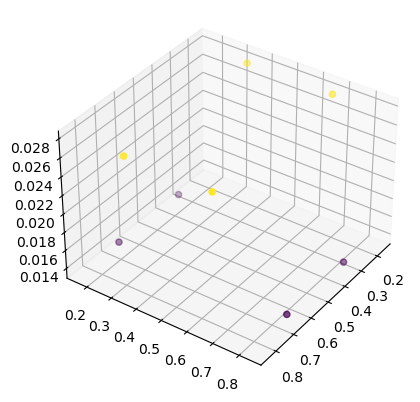

In [208]:
show_scalar_field(P0(), nodes2coord, elems2nodes, view(u, nedges+1:nedges+nelems))